In [1]:
from pylab import rcParams
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
import sklearn.metrics as sm
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.utils.multiclass import type_of_target
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cophenet

from collections import Counter

# 3rd laboratory work for the course Machine Learning
##### Student: Hristijan Stojchevski 161278

In [2]:
dataset_full = np.loadtxt("../data/cortex-nuclear/Data_Cortex_Nuclear.csv",np.object,delimiter=",",skiprows=1)
target = dataset_full[:,-1].copy()
target[target == 'c-CS-m'] = 0
target[target == 'c-SC-m'] = 1
target[target == 'c-CS-s'] = 2
target[target == 'c-SC-s'] = 3
target[target == 't-CS-s'] = 4
target[target == 't-CS-m'] = 6
target[target == 't-SC-m'] = 7
target[target == 't-SC-s'] = 5
dataset_raw = dataset_full[:,1:-4]
dataset_raw[dataset_raw == ''] = 0
dataset = dataset_raw[:,:].astype(np.float)
scaler = MinMaxScaler()
X = scaler.fit_transform(dataset)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(target)
print(type_of_target(y))
skf = StratifiedKFold(n_splits=4)

pca_2D = PCA(n_components=2)
pca_3D = PCA(n_components=3)
pca_2D.fit(X)
pca_3D.fit(X)
pca_t2 = pca_2D.fit_transform(X)
pca_t3 = pca_3D.fit_transform(X)
pca_t2 = np.ascontiguousarray(pca_t2)
pca_t3 = np.ascontiguousarray(pca_t3)
print(pca_t2)
# X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.25, random_state=42)
train_index, test_index = next(iter(skf.split(X, y)))
X_train = X[train_index]
X_test = X[test_index]
y_train = target[train_index]
y_test = target[test_index]
print(len(X_train))

y_test = label_encoder.fit_transform(y_test)
print(type_of_target(y_test))
y_train = label_encoder.fit_transform(y_train)
print(type_of_target(y_train))


train_index, test_index = next(iter(skf.split(pca_t2, y)))
pcaX_train = pca_t2[train_index]
pcaX_test = pca_t2[test_index]
pcay_train = target[train_index]
pcay_test = target[test_index]


multiclass
[[-0.36157371  0.69654267]
 [-0.22610853  0.67361858]
 [-0.23924751  0.73229954]
 ...
 [ 0.7751637  -0.20150736]
 [ 0.64964829 -0.28272475]
 [ 0.38426326 -0.25846771]]
810
multiclass
multiclass


### Visualization
* 2D

[[-0.36157371  0.69654267]
 [-0.22610853  0.67361858]
 [-0.23924751  0.73229954]
 ...
 [ 0.7751637  -0.20150736]
 [ 0.64964829 -0.28272475]
 [ 0.38426326 -0.25846771]]


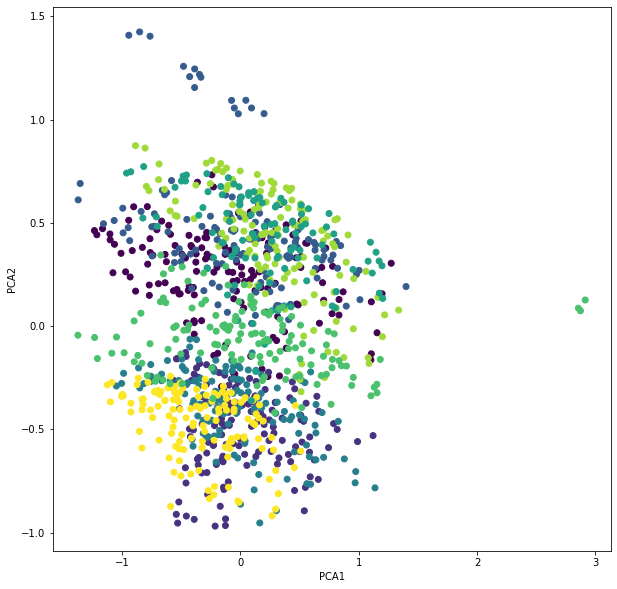

C:\Users\HS-Rn7\anaconda3\envs\kolokvium\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


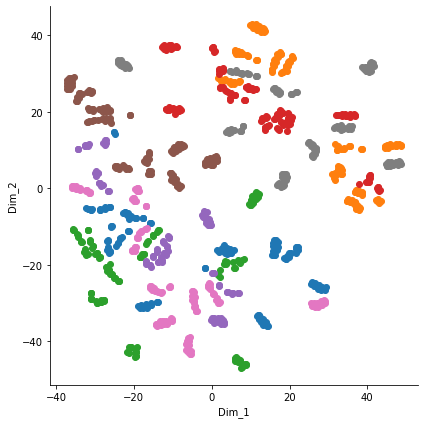

In [3]:
plt.figure(figsize=(10,10))
plt.scatter(pca_t2[:,0],pca_t2[:,1],c=target)
plt.xlabel("PCA1")
print(pca_t2)
plt.ylabel("PCA2")
plt.show()

tsne = TSNE(n_components=2, random_state=15)
x_embed = tsne.fit_transform(X)
x_embed = np.vstack((x_embed.T, y)).T
tsne_df = pd.DataFrame(data=x_embed, columns=("Dim_1", "Dim_2", "label"))

sb.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, "Dim_1", "Dim_2")
plt.show()

- 3D

[[-0.36157371  0.69654264 -0.35669952]
 [-0.22610852  0.67361851 -0.31818981]
 [-0.2392475   0.73229944 -0.28927743]
 ...
 [ 0.77516368 -0.20150726  0.90179076]
 [ 0.64964827 -0.28272462  0.98333977]
 [ 0.38426324 -0.25846758  0.9535331 ]]


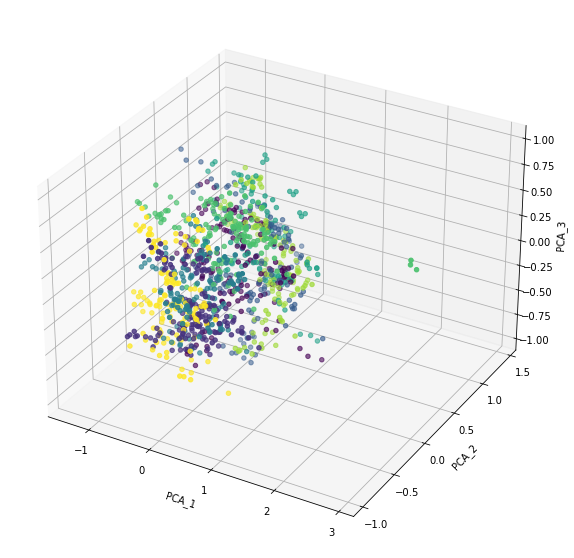

In [4]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_t3[:,0],pca_t3[:,1],pca_t3[:,2],c=target)
ax.set_xlabel('PCA_1')
ax.set_ylabel("PCA_2")
ax.set_zlabel("PCA_3")
print(pca_t3)
plt.show()


In [5]:
# Function for ellipses
colors = ['blue','navy','green','turquoise','orange','darkorange','red','purple']
def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')


- Train/test split visualization

8


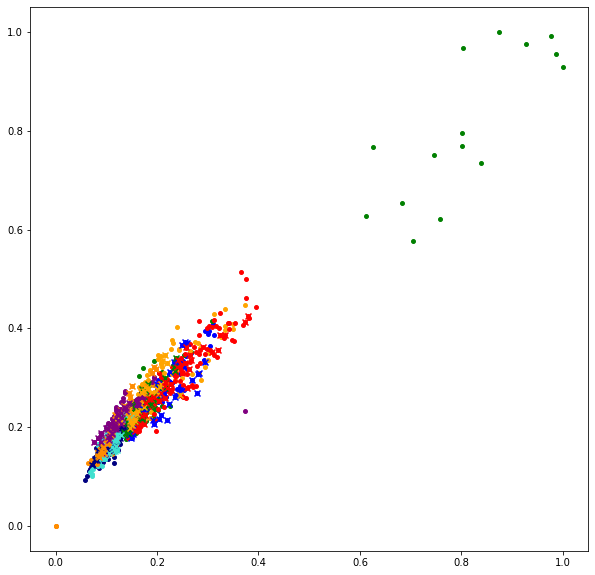

In [6]:
classes = np.unique(dataset_full[:,-1])
n_classes = len(np.unique(y_train))
print(n_classes)
plt.figure(figsize=(10,10))
for n, color in enumerate(colors):
    data = X[target == n]
    plt.scatter(data[:, 0], data[:, 1], s=15.5, color=color,
                label=classes[n])
for n, color in enumerate(colors):
    data = X_test[y_test == n]
    plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)
plt.show()


### Fit and visualize the results of 4 Gaussian Mixture Models (GMM) with different covariance matrices (spherical, diagonal, tied, full) on the Iris dataset

C:\Users\HS-Rn7\anaconda3\envs\kolokvium\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
C:\Users\HS-Rn7\anaconda3\envs\kolokvium\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


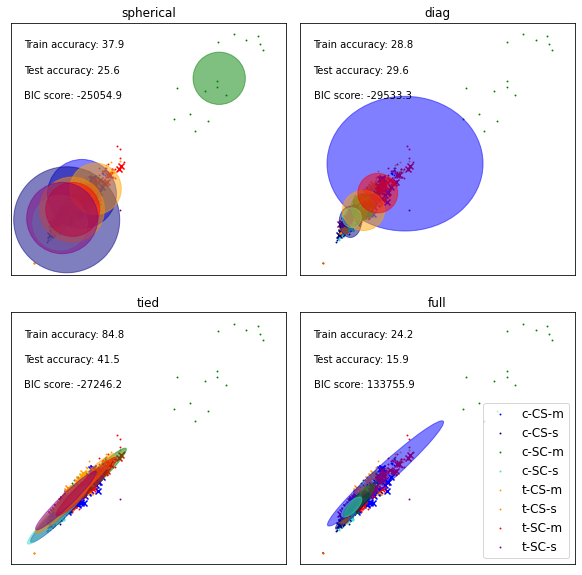

In [7]:
# Try GMMs using different types of covariances.
estimators = {cov_type: GaussianMixture(n_components=n_classes,
              covariance_type=cov_type, max_iter=20, random_state=0)
              for cov_type in ['spherical', 'diag', 'tied', 'full']} #  Make sure to change max_iter

n_estimators = len(estimators)
plt.figure(figsize=(4 * n_estimators // 2, 8))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)

for index, (name, estimator) in enumerate(estimators.items()):
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])

    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = X[target == n]
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color,
                    label=classes[n])
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.text(0.05, 0.7, 'BIC score: %.1f' % estimator.bic(X_test),
             transform=h.transAxes)
    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))
plt.show()

### Predictions
#### Visualize the probabilities of belonging to cluster 2 for all points of the Mice dataset using the 4 trained Gaussian Mixture Models (GMM) from above. (For each point, soft clustering techniques such as GMM return a probability of belonging to each cluster, with brighter colors representing higher probabilities and darker colors representing lower probabilities)

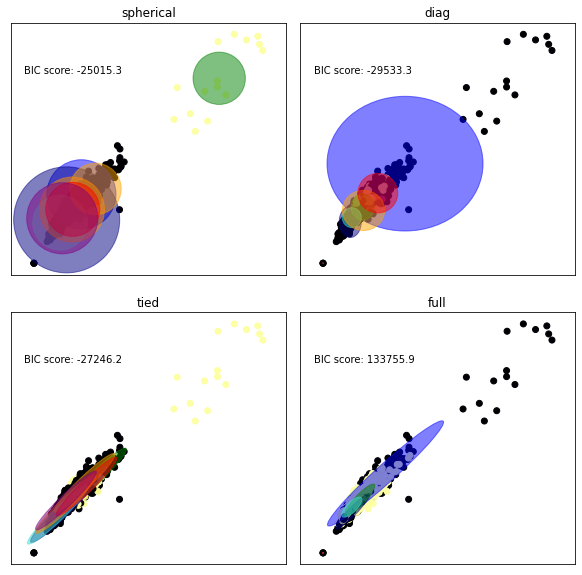

In [8]:
estimators = {cov_type: GaussianMixture(n_components=n_classes,
              covariance_type=cov_type, max_iter=30, random_state=0)
              for cov_type in ['spherical', 'diag', 'tied', 'full']}

n_estimators = len(estimators)

plt.figure(figsize=(4 * n_estimators // 2, 8))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)


for index, (name, estimator) in enumerate(estimators.items()):
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])

    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    class2_probabilities = estimator.predict_proba(X_train)[:,2]
    data = X_train
    plt.scatter(data[:,0], data[:,1], marker='o', norm = mpl.colors.Normalize(0,1), c=class2_probabilities, cmap="inferno")

    y_pred_GMM = estimator.predict_proba(X_test)
    class2_probabilities = y_pred_GMM[:,2]
    data = X_test
    plt.scatter(data[:,0], data[:,1], marker='o', norm = mpl.colors.Normalize(0,1), c=class2_probabilities, cmap="inferno")
    plt.xticks(())
    plt.yticks(())
    plt.title(name)
    plt.text(0.05, 0.8, 'BIC score: %.1f' % estimator.bic(X_test),
             transform=h.transAxes)
plt.show()

y_pred_GMM = estimators["tied"].fit_predict(X)

## K-means

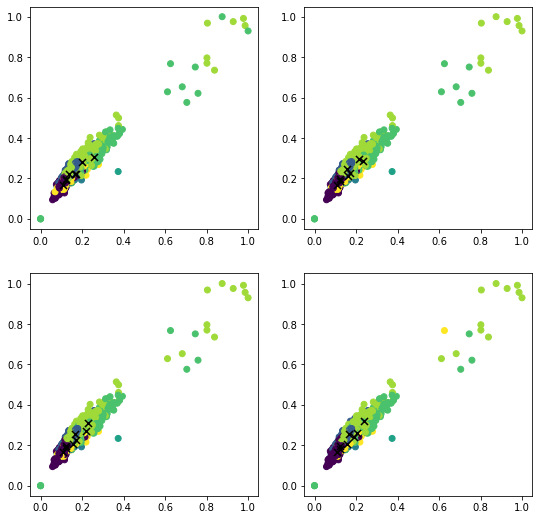

In [9]:
iterations = [1,2,3,10]

fig2 = plt.figure(figsize=(9, 9))
plt.title("K-means iterations")
for i in range(len(iterations)):
    plt.subplot(2, 2, i+1)
    estimator = KMeans(init='random', n_clusters=8, random_state=170, n_init=1, max_iter=iterations[i])
    y_pred_Kmeans_random = estimator.fit_predict(X)

    plt.scatter(X[:, 0], X[:, 1], c=y_pred_Kmeans_random)
    plt.scatter(estimator.cluster_centers_[:,0],estimator.cluster_centers_[:,1], s=50, marker='x', color="black")

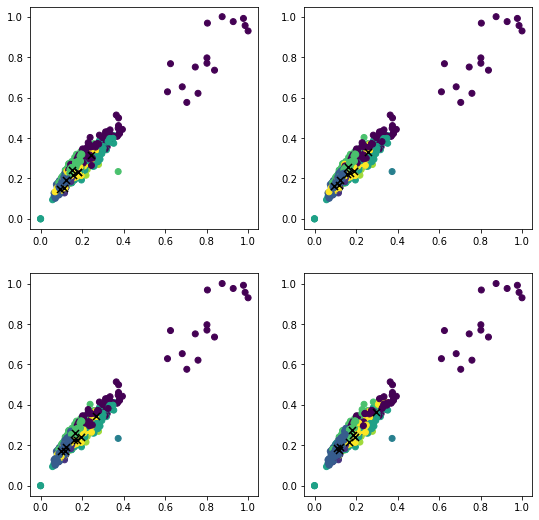

In [10]:
iterations = [1,2,3,10]

fig2 = plt.figure(figsize=(9, 9))
plt.title("K-means iterations")
for i in range(len(iterations)):
    plt.subplot(2, 2, i+1)
    estimator = KMeans(init='k-means++', n_clusters=8, random_state=170, n_init=1, max_iter=iterations[i])
    y_pred_Kmeans = estimator.fit_predict(X)
    plt.scatter(X[:, 0], X[:, 1], c=y_pred_Kmeans)
    plt.scatter(estimator.cluster_centers_[:,0],estimator.cluster_centers_[:,1], s=50, marker='x', color="black")

## Hierarchical clustering

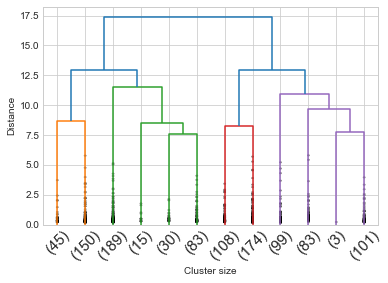

In [11]:
plt.figure(figsize=(10,3))
%matplotlib inline
plt.style.use('seaborn-whitegrid')
Z = linkage(X,"ward")
dendrogram(Z, truncate_mode='lastp', p=12, leaf_rotation=45.,leaf_font_size=15.,show_contracted=True)
plt.xlabel('Cluster size')
plt.ylabel('Distance')

plt.axhline(y=500)
plt.axhline(y=150)
plt.show()

In [12]:
k = n_classes
Hclustering = AgglomerativeClustering(n_clusters=k, affinity='euclidean',linkage='ward',)
y_pred_Hierarchy = Hclustering.fit_predict(X)
print("Affinity: euclidean, linkage: ward", sm.accuracy_score(y, Hclustering.labels_))

y_pred = Hclustering.fit_predict(X_test)
print("This model on test dataset is with precision: ", sm.accuracy_score(y_test, y_pred))
Hclustering = AgglomerativeClustering(n_clusters=k, affinity='euclidean',linkage='complete',)
Hclustering.fit(X)
print("Affinity: euclidean, linkage: complete", sm.accuracy_score(y, Hclustering.labels_))

Hclustering = AgglomerativeClustering(n_clusters=k, affinity='euclidean',linkage='average',)
Hclustering.fit(X)
print("Affinity: euclidean, linkage: average", sm.accuracy_score(y, Hclustering.labels_))

Hclustering = AgglomerativeClustering(n_clusters=k, affinity='manhattan',linkage='complete',)
Hclustering.fit(X)
print("Affinity: manhatan, linkage: ward", sm.accuracy_score(y, Hclustering.labels_))

Hclustering = AgglomerativeClustering(n_clusters=k, affinity='manhattan',linkage='average',)
Hclustering.fit(X)
print("Affinity: manhatan, linkage: ward", sm.accuracy_score(y, Hclustering.labels_))

Affinity: euclidean, linkage: ward 0.20555555555555555
This model on test dataset is with precision:  0.05555555555555555
Affinity: euclidean, linkage: complete 0.1287037037037037
Affinity: euclidean, linkage: average 0.15
Affinity: manhatan, linkage: ward 0.10740740740740741
Affinity: manhatan, linkage: ward 0.09444444444444444


## DBSCAN

In [13]:
model_1 = DBSCAN(eps=0.75, min_samples=9)
model_1.fit(X)
model_2 = DBSCAN(eps=0.5, min_samples=4)
model_2.fit(X)
model_3 = DBSCAN(eps=0.5, min_samples=2)
model_3.fit(X)

outlier1 = pd.DataFrame(X)
print(Counter(model_1.labels_))
print(Counter(model_2.labels_))
print(Counter(model_3.labels_))

Counter({0: 377, 7: 200, -1: 123, 6: 30, 13: 30, 8: 24, 1: 22, 2: 15, 4: 15, 5: 15, 9: 15, 10: 15, 14: 15, 15: 15, 16: 15, 17: 15, 18: 15, 19: 15, 23: 15, 24: 15, 25: 15, 21: 13, 3: 12, 12: 10, 20: 10, 22: 10, 11: 9})
Counter({-1: 207, 31: 38, 19: 30, 68: 18, 0: 15, 2: 15, 5: 15, 8: 15, 11: 15, 12: 15, 15: 15, 17: 15, 30: 15, 34: 15, 43: 15, 46: 15, 52: 15, 53: 15, 54: 15, 59: 15, 60: 15, 66: 15, 69: 15, 70: 15, 74: 15, 76: 15, 39: 14, 77: 14, 13: 12, 14: 12, 18: 12, 20: 12, 28: 12, 40: 12, 47: 12, 71: 12, 26: 11, 35: 11, 6: 9, 7: 9, 9: 9, 16: 9, 23: 9, 27: 9, 29: 9, 41: 9, 44: 9, 50: 9, 56: 9, 57: 9, 58: 9, 61: 9, 78: 9, 1: 8, 3: 8, 21: 8, 32: 8, 72: 8, 75: 8, 4: 6, 22: 6, 24: 6, 25: 6, 33: 6, 36: 6, 37: 6, 45: 6, 48: 6, 49: 6, 51: 6, 55: 6, 62: 6, 64: 6, 65: 6, 67: 6, 73: 6, 79: 6, 10: 5, 38: 5, 42: 5, 63: 5})
Counter({-1: 56, 62: 38, 29: 30, 117: 18, 0: 15, 3: 15, 6: 15, 13: 15, 16: 15, 17: 15, 22: 15, 26: 15, 61: 15, 65: 15, 77: 15, 80: 15, 88: 15, 89: 15, 90: 15, 102: 15, 103: 15,

DBSCAN model 3 acurr:  0.05555555555555555


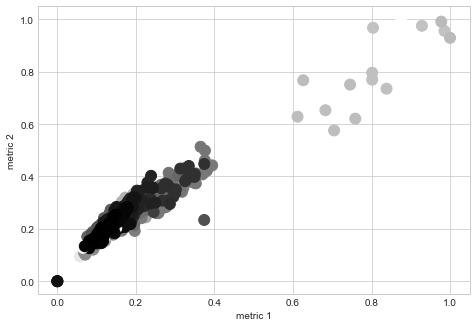

In [14]:
fig = plt.figure()
ax = fig.add_axes([.1,.1,1,1])
colors = model_3.labels_
ax.scatter(X[:,0], X[:,1], c = colors, s = 120)
ax.set_xlabel("metric 1")
ax.set_ylabel('metric 2')
y_pred_DBSCAN = model_3.fit_predict(X)
y_pred = model_3.fit_predict(X_test)
print("DBSCAN model 3 acurr: ", sm.accuracy_score(y_test, y_pred))

## VISUALIZATION

- 2D GMM

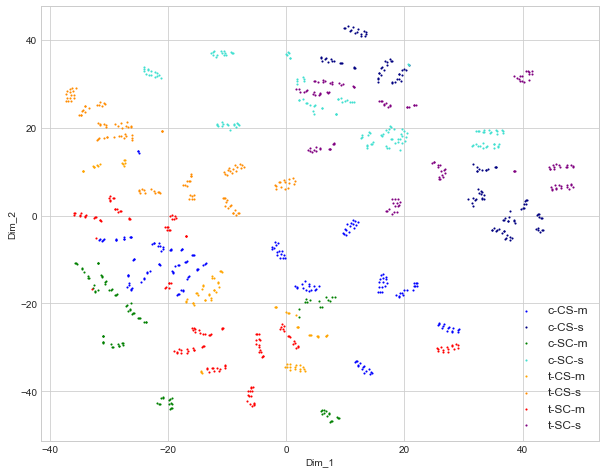

In [15]:
colors = ['blue','navy','green','turquoise','orange','darkorange','red','purple']

tsne = TSNE(n_components=2, random_state=15)
x_embed = tsne.fit_transform(X)
# x_embed = np.vstack((x_embed.T, y_pred_GMM)).T
# tsne_df = pd.DataFrame(data=x_embed, columns=("Dim_1", "Dim_2", "label"))
plt.figure(figsize=(10,8))
for n, color in enumerate(colors):
    data = x_embed[y_pred_GMM == n]
    plt.scatter(data[:,0], data[:,1], s=1.2, color=color, label=classes[n])
# sb.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, "Dim_1", "Dim_2")
plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))
plt.xlabel("Dim_1")
plt.ylabel("Dim_2")
plt.show()

- 3D GMM

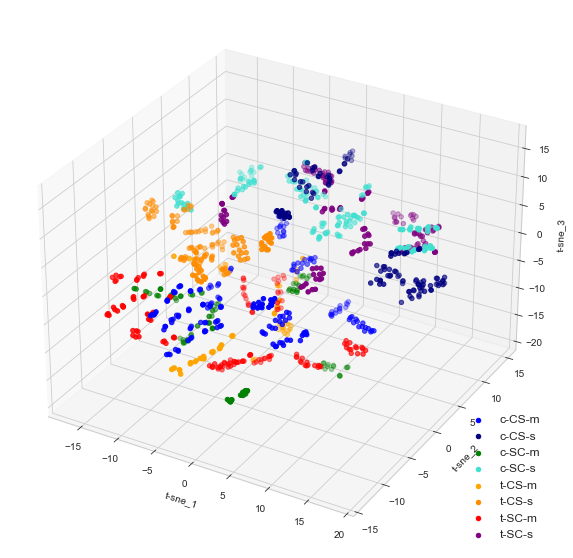

In [16]:
tsne3 = TSNE(n_components=3, random_state=15)
x3_embed = tsne3.fit_transform(X)
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
for n, color in enumerate(colors):
    data = x3_embed[y_pred_GMM == n]
    ax.scatter(data[:,0], data[:,1], data[:,2], color=color, label=classes[n])
plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))
ax.set_xlabel('t-sne_1')
ax.set_ylabel("t-sne_2")
ax.set_zlabel("t-sne_3")
plt.show()

- 2D Kmeans random

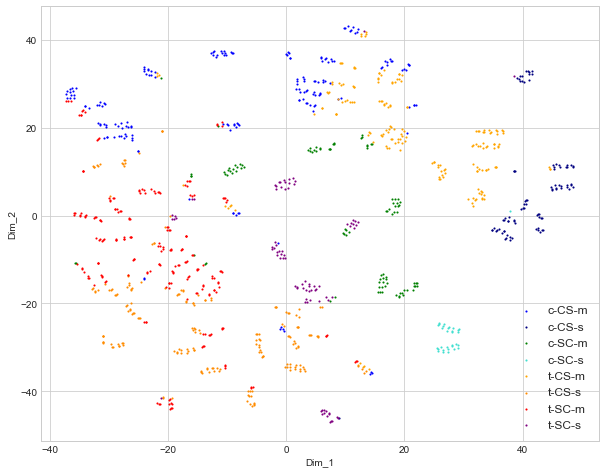

In [17]:
tsne = TSNE(n_components=2, random_state=15)
x_embed = tsne.fit_transform(X)
# x_embed = np.vstack((x_embed.T, y_pred_GMM)).T
# tsne_df = pd.DataFrame(data=x_embed, columns=("Dim_1", "Dim_2", "label"))
plt.figure(figsize=(10,8))
for n, color in enumerate(colors):
    data = x_embed[y_pred_Kmeans_random == n]
    plt.scatter(data[:,0], data[:,1], s=1.2, color=color, label=classes[n])
# sb.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, "Dim_1", "Dim_2")
plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))
plt.xlabel("Dim_1")
plt.ylabel("Dim_2")
plt.show()

- 3D Kmeans

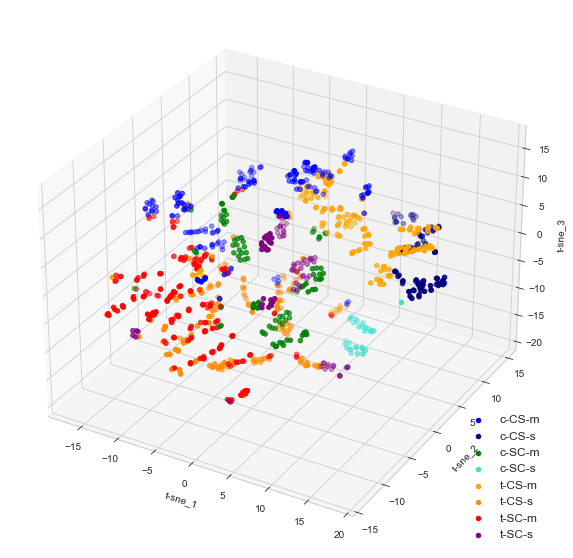

In [18]:
tsne3 = TSNE(n_components=3, random_state=15)
x3_embed = tsne3.fit_transform(X)
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
for n, color in enumerate(colors):
    data = x3_embed[y_pred_Kmeans_random == n]
    ax.scatter(data[:,0], data[:,1], data[:,2], color=color, label=classes[n])
plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))
ax.set_xlabel('t-sne_1')
ax.set_ylabel("t-sne_2")
ax.set_zlabel("t-sne_3")
plt.show()

- 2D Kmeans

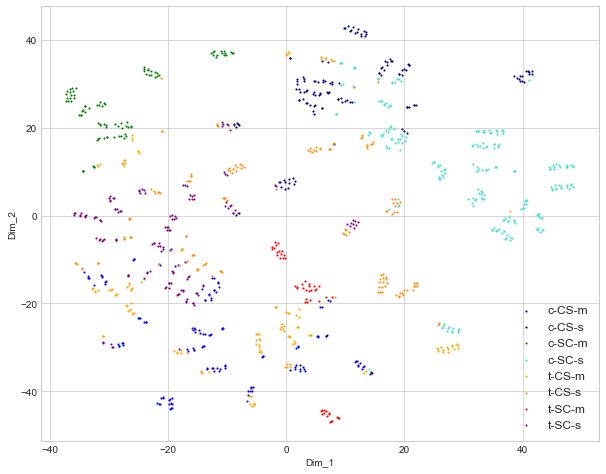

In [19]:
tsne = TSNE(n_components=2, random_state=15)
x_embed = tsne.fit_transform(X)
# x_embed = np.vstack((x_embed.T, y_pred_GMM)).T
# tsne_df = pd.DataFrame(data=x_embed, columns=("Dim_1", "Dim_2", "label"))
plt.figure(figsize=(10,8))
for n, color in enumerate(colors):
    data = x_embed[y_pred_Kmeans == n]
    plt.scatter(data[:,0], data[:,1], s=1.2, color=color, label=classes[n])
# sb.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, "Dim_1", "Dim_2")
plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))
plt.xlabel("Dim_1")
plt.ylabel("Dim_2")
plt.show()


- 3D Kmeans

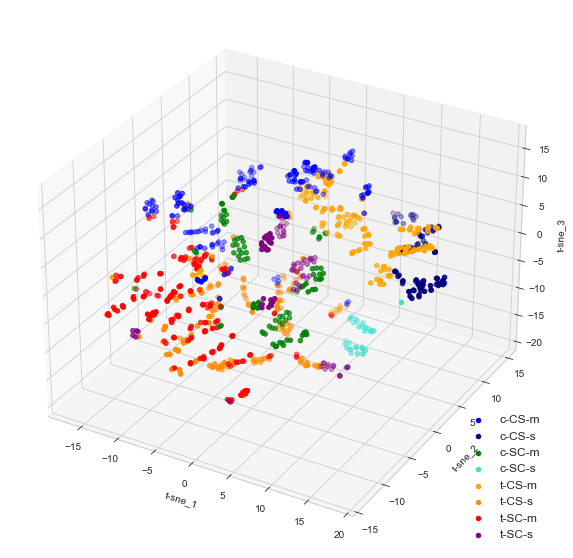

In [20]:
tsne3 = TSNE(n_components=3, random_state=15)
x3_embed = tsne3.fit_transform(X)
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
for n, color in enumerate(colors):
    data = x3_embed[y_pred_Kmeans_random == n]
    ax.scatter(data[:,0], data[:,1], data[:,2], color=color, label=classes[n])
plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))
ax.set_xlabel('t-sne_1')
ax.set_ylabel("t-sne_2")
ax.set_zlabel("t-sne_3")
plt.show()


- 2D Hierarchy

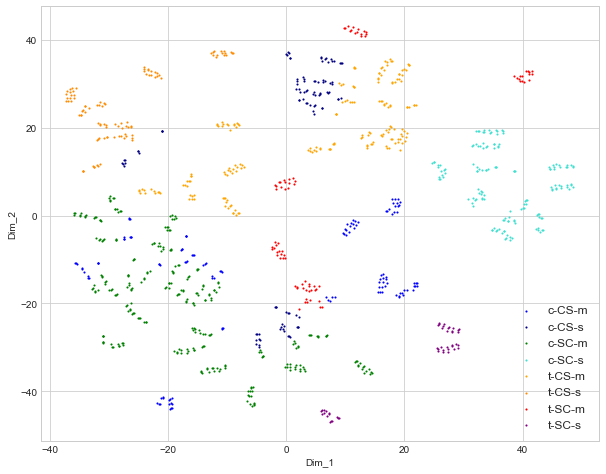

In [21]:
tsne = TSNE(n_components=2, random_state=15)
x_embed = tsne.fit_transform(X)
# x_embed = np.vstack((x_embed.T, y_pred_GMM)).T
# tsne_df = pd.DataFrame(data=x_embed, columns=("Dim_1", "Dim_2", "label"))
plt.figure(figsize=(10,8))
for n, color in enumerate(colors):
    data = x_embed[y_pred_Hierarchy == n]
    plt.scatter(data[:,0], data[:,1], s=1.2, color=color, label=classes[n])
# sb.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, "Dim_1", "Dim_2")
plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))
plt.xlabel("Dim_1")
plt.ylabel("Dim_2")
plt.show()


- 3D Hierarchy

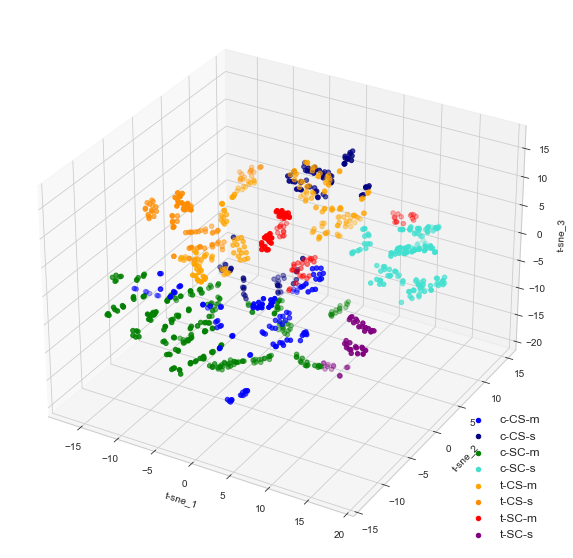

In [22]:
tsne3 = TSNE(n_components=3, random_state=15)
x3_embed = tsne3.fit_transform(X)
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
for n, color in enumerate(colors):
    data = x3_embed[y_pred_Hierarchy == n]
    ax.scatter(data[:,0], data[:,1], data[:,2], color=color, label=classes[n])
plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))
ax.set_xlabel('t-sne_1')
ax.set_ylabel("t-sne_2")
ax.set_zlabel("t-sne_3")
plt.show()


- 2D DBSCAN

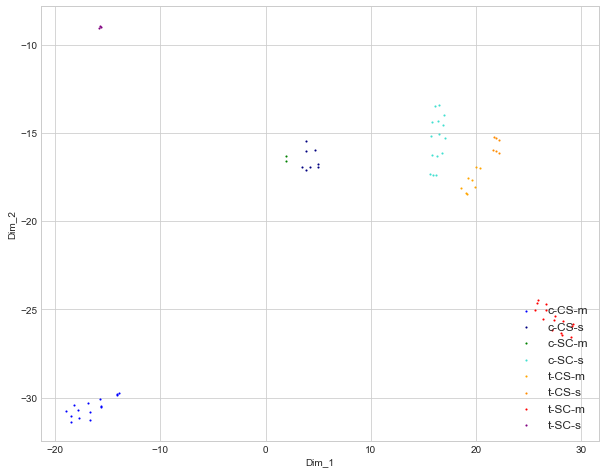

In [23]:
tsne = TSNE(n_components=2, random_state=15)
x_embed = tsne.fit_transform(X)
# x_embed = np.vstack((x_embed.T, y_pred_GMM)).T
# tsne_df = pd.DataFrame(data=x_embed, columns=("Dim_1", "Dim_2", "label"))
plt.figure(figsize=(10,8))
for n, color in enumerate(colors):
    data = x_embed[y_pred_DBSCAN == n]
    plt.scatter(data[:,0], data[:,1], s=1.2, color=color, label=classes[n])
# sb.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, "Dim_1", "Dim_2")
plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))
plt.xlabel("Dim_1")
plt.ylabel("Dim_2")
plt.show()

- 3D DBSCAN

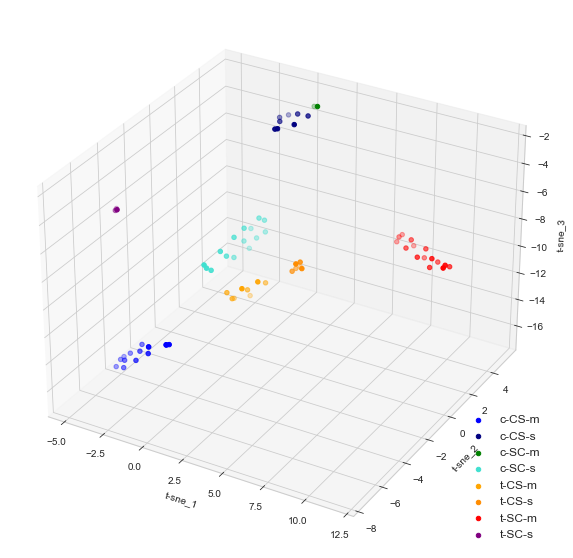

In [24]:
tsne3 = TSNE(n_components=3, random_state=15)
x3_embed = tsne3.fit_transform(X)
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
for n, color in enumerate(colors):
    data = x3_embed[y_pred_DBSCAN == n]
    ax.scatter(data[:,0], data[:,1], data[:,2], color=color, label=classes[n])
plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))
ax.set_xlabel('t-sne_1')
ax.set_ylabel("t-sne_2")
ax.set_zlabel("t-sne_3")
plt.show()


8


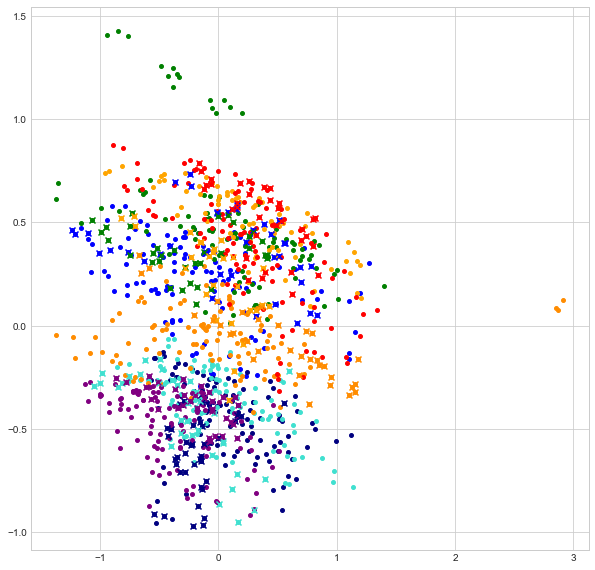

In [25]:
# - Train/test split visualization

classes = np.unique(dataset_full[:,-1])
n_classes = len(np.unique(y_train))
print(n_classes)
plt.figure(figsize=(10,10))
for n, color in enumerate(colors):
    data = pca_t2[target == n]
    plt.scatter(data[:, 0], data[:, 1], s=15.5, color=color,
                label=classes[n])
for n, color in enumerate(colors):
    data = pcaX_test[pcay_test == n]
    plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)
plt.show()


### Fit and visualize the results of 4 Gaussian Mixture Models (GMM) with different covariance matrices (spherical, diagonal, tied, full) on the Iris dataset

C:\Users\HS-Rn7\anaconda3\envs\kolokvium\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


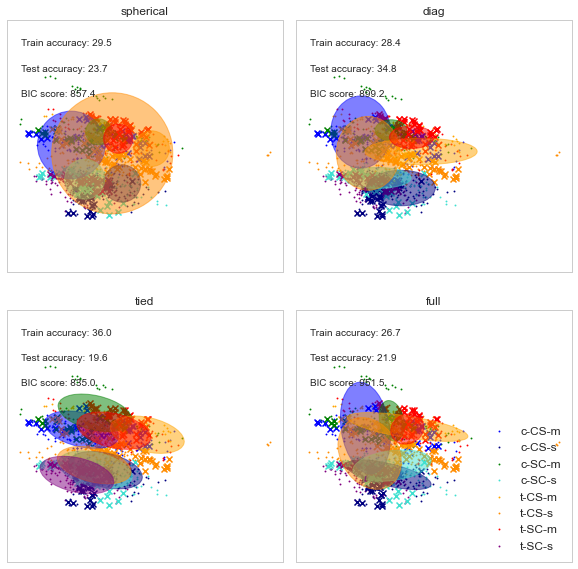

In [26]:
# Try GMMs using different types of covariances.
estimators = {cov_type: GaussianMixture(n_components=n_classes,
              covariance_type=cov_type, max_iter=20, random_state=0)
              for cov_type in ['spherical', 'diag', 'tied', 'full']} #  Make sure to change max_iter

n_estimators = len(estimators)
plt.figure(figsize=(4 * n_estimators // 2, 8))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)

for index, (name, estimator) in enumerate(estimators.items()):
    estimator.means_init = np.array([pcaX_train[pcay_train == i].mean(axis=0)
                                    for i in range(n_classes)])

    estimator.fit(pcaX_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = pca_t2[target == n]
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color,
                    label=classes[n])
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = pcaX_test[pcay_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)

    y_train_pred = estimator.predict(pcaX_train)
    train_accuracy = np.mean(y_train_pred.ravel() == pcay_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = estimator.predict(pcaX_test)
    test_accuracy = np.mean(y_test_pred.ravel() == pcay_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.text(0.05, 0.7, 'BIC score: %.1f' % estimator.bic(pcaX_test),
             transform=h.transAxes)
    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))
plt.show()


### Predictions
#### Visualize the probabilities of belonging to cluster 2 for all points of the Mice dataset using the 4 trained Gaussian Mixture Models (GMM) from above. (For each point, soft clustering techniques such as GMM return a probability of belonging to each cluster, with brighter colors representing higher probabilities and darker colors representing lower probabilities)

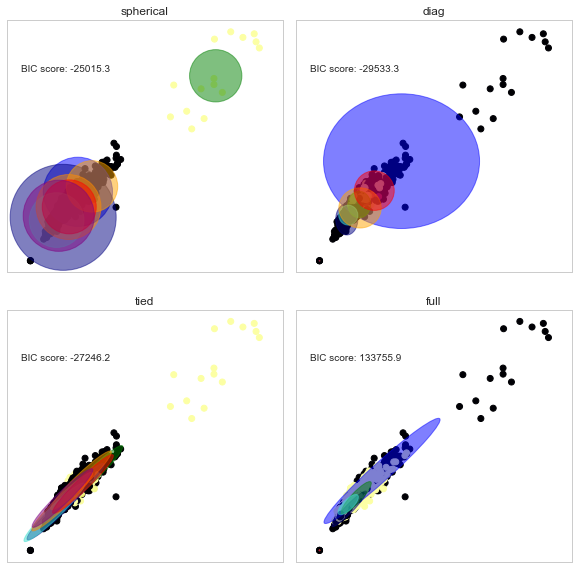

In [27]:
estimators = {cov_type: GaussianMixture(n_components=n_classes,
              covariance_type=cov_type, max_iter=30, random_state=0)
              for cov_type in ['spherical', 'diag', 'tied', 'full']}

n_estimators = len(estimators)

plt.figure(figsize=(4 * n_estimators // 2, 8))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)


for index, (name, estimator) in enumerate(estimators.items()):
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])

    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    class2_probabilities = estimator.predict_proba(X_train)[:,2]
    data = X_train
    plt.scatter(data[:,0], data[:,1], marker='o', norm = mpl.colors.Normalize(0,1), c=class2_probabilities, cmap="inferno")

    class2_probabilities = estimator.predict_proba(X_test)[:,2]
    data = X_test
    plt.scatter(data[:,0], data[:,1], marker='o', norm = mpl.colors.Normalize(0,1), c=class2_probabilities, cmap="inferno")
    plt.xticks(())
    plt.yticks(())
    plt.title(name)
    plt.text(0.05, 0.8, 'BIC score: %.1f' % estimator.bic(X_test),
             transform=h.transAxes)
plt.show()


## K-means

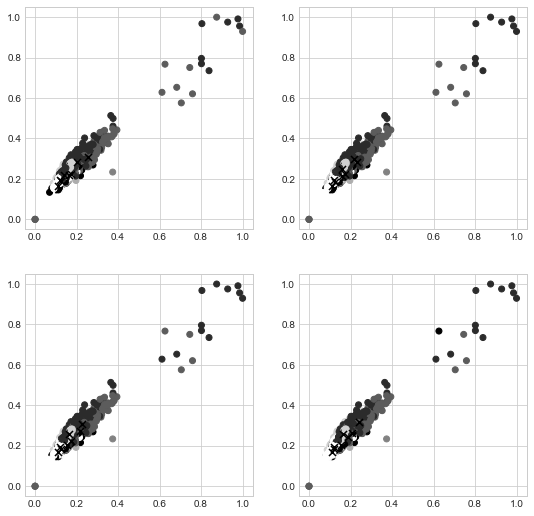

In [28]:
iterations = [1,2,3,10]

fig2 = plt.figure(figsize=(9, 9))
plt.title("K-means iterations")
for i in range(len(iterations)):
    plt.subplot(2, 2, i+1)
    estimator = KMeans(init='random', n_clusters=8, random_state=170, n_init=1, max_iter=iterations[i])
    y_pred = estimator.fit_predict(X)

    plt.scatter(X[:, 0], X[:, 1], c=y_pred)
    plt.scatter(estimator.cluster_centers_[:,0],estimator.cluster_centers_[:,1], s=50, marker='x', color="black")


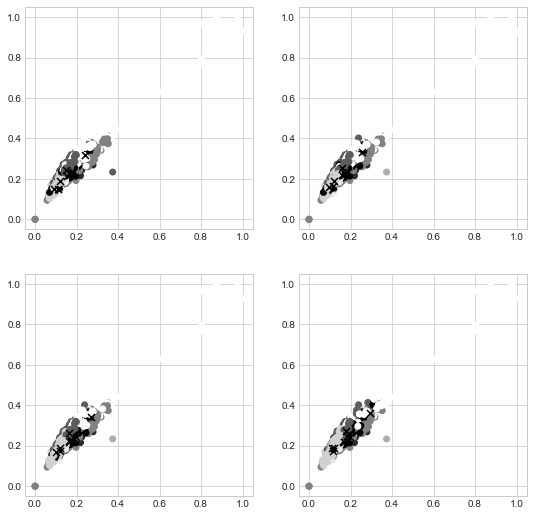

In [29]:
iterations = [1,2,3,10]

fig2 = plt.figure(figsize=(9, 9))
plt.title("K-means iterations")
for i in range(len(iterations)):
    plt.subplot(2, 2, i+1)
    estimator = KMeans(init='k-means++', n_clusters=8, random_state=170, n_init=1, max_iter=iterations[i])
    y_pred = estimator.fit_predict(X)
    plt.scatter(X[:, 0], X[:, 1], c=y_pred)
    plt.scatter(estimator.cluster_centers_[:,0],estimator.cluster_centers_[:,1], s=50, marker='x', color="black")


